Primer punto:

Initial distance: 97.84533333872459
Generation 50 Distance:  54.47906848367993
Generation 100 Distance:  45.76768613606059
Generation 150 Distance:  44.53917955639888
Generation 200 Distance:  43.87886746406842
Generation 250 Distance:  42.59599224945869
Generation 300 Distance:  42.43573510951226
Generation 350 Distance:  40.13356433943902
Generation 400 Distance:  41.776181030124924
Generation 450 Distance:  41.609829110503924
Generation 500 Distance:  40.845649780818


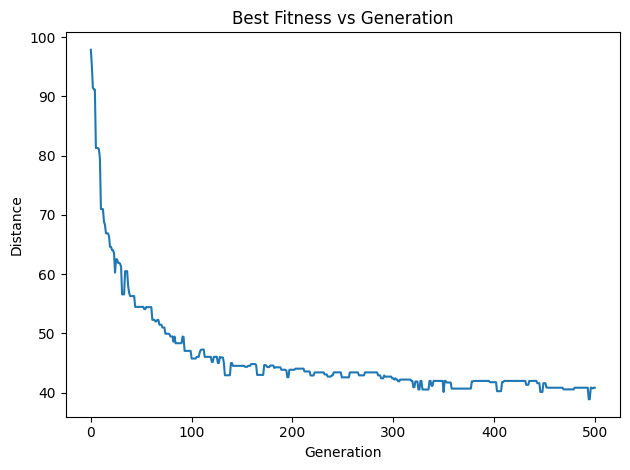

[(12), (6), (4), (26), (18), (14), (22), (27), (20), (5), (11), (10), (25), (19), (7), (21), (0), (8), (16), (9), (13), (3), (17), (2), (24), (1), (23), (15)]


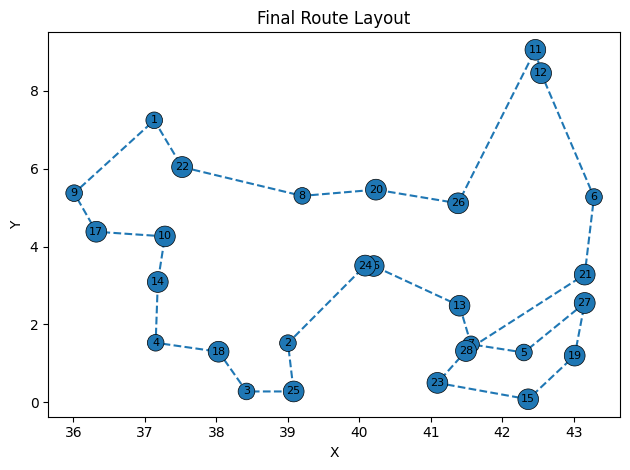

[(0), (1), (2), (3), (4), (5), (6), (7), (8), (9), (10), (11), (12), (13), (14), (15), (16), (17), (18), (19), (20), (21), (22), (23), (24), (25), (26), (27)]


In [ ]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import random


# Create class to handle "cities"

class City:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.name) + ")"


# Create a fitness function

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness


# Create our initial population
# Route generator
# This method randomizes the order of the cities, this mean that this method creates a random individual.
def createRoute(cityList):
    primer_elemento = cityList[0]
    resto_elementos = random.sample(cityList[1:], len(cityList)-1)
    route = [primer_elemento] + resto_elementos
    return route


# Create first "population" (list of routes)
# This method created a random population of the specified size.

def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


# Create the genetic algorithm
# Rank individuals
# This function takes a population and orders it in descending order using the fitness of each individual
def rankRoutes(population):
    fitnessResults = {}
    sortness=[]
    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    sorted_results = sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)
    linea= tuple[0, 0.023402489727744703]
    for j in range(0, len(sorted_results)):
        if sorted_results[j]==linea:
            print(sorted_results[j])
            sortness.append(sorted_results[j])
    return sorted_results


# Create a selection function that will be used to make the list of parent routes

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100 * random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i, 3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults


# Create mating pool

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool


# Create a crossover function for two parents to create one child
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]
    # print(startGene, endGene)

    # print(parent1)
    # print(parent2)

    # print(childP1)
    # print(childP2)
    child = childP1 + childP2

    # print(child)
    return child


# Create function to run crossover over full mating pool

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool) - i - 1])
        children.append(child)
    return children


# Create function to mutate a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if (random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual


# Create function to run mutation over entire population

def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop


# Put all steps together to create the next generation

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration


# Final step: create the genetic algorithm

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = [1 / rankRoutes(pop)[0][1]]
    print("Initial distance: " + str(progress[0]))

    for i in range(1, generations + 1):

        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if i % 50 == 0:
            print('Generation ' + str(i), "Distance: ", progress[i])

    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Best Fitness vs Generation')
    plt.tight_layout()
    plt.show()
    # print('progress max '+progress[np.argmax[progress]])
    print(bestRoute)
    return bestRoute


# Create list of cities
coordenadas = [
    (37.13, 7.24),
    (39.00, 1.52),
    (38.42, 0.28),
    (37.15, 1.53),
    (42.30, 1.28),
    (43.28, 5.27),
    (41.56, 1.49),
    (39.20, 5.30),
    (36.01, 5.37),
    (37.28, 4.26),
    (42.46, 9.05),
    (42.54, 8.45),
    (41.40, 2.48),
    (37.18, 3.09),
    (42.36, 0.08),
    (40.20, 3.50),
    (36.32, 4.38),
    (38.03, 1.30),
    (43.01, 1.20),
    (40.23, 5.46),
    (43.15, 3.28),
    (37.52, 6.04),
    (41.09, 0.50),
    (40.08, 3.51),
    (39.08, 0.28),
    (41.38, 5.11),
    (43.15, 2.55),
    (41.49, 1.32)
]
cityList = []

for i in range(len(coordenadas)):
    cityList.append(City(name=i, x=coordenadas[i][0], y=coordenadas[i][1]))

best_route = geneticAlgorithm(population=cityList, popSize=120, eliteSize=20, mutationRate=0.01, generations=500)
x = []
y = []
for i in best_route:
    x.append(i.x)
    y.append(i.y)
x.append(best_route[0].x)
y.append(best_route[0].y)
plt.plot(x, y, '--o')
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
plt.title('Final Route Layout')
bbox_props = dict(boxstyle="circle,pad=0.3", fc='C0', ec="black", lw=0.5)
for i in range(1, len(cityList) + 1):
    ax.text(cityList[i - 1].x, cityList[i - 1].y, str(i), ha="center", va="center",
            size=8,
            bbox=bbox_props)
plt.tight_layout()
plt.show()
print(cityList)

Segundo punto:

Generación 0
La mejor solución encontrada es: [-0.18861194 -1.23585777]
La aptitud correspondiente es: 70.03948485965078
Generación 10
La mejor solución encontrada es: [-0.04451169 -0.99912155]
La aptitud correspondiente es: 3.5180609446112454
Generación 20
La mejor solución encontrada es: [ 2.17935709e-04 -9.99121546e-01]
La aptitud correspondiente es: 3.000303698723011
Generación 30
La mejor solución encontrada es: [ 2.17935709e-04 -9.99121546e-01]
La aptitud correspondiente es: 3.000303698723011
Generación 40
La mejor solución encontrada es: [ 2.17935709e-04 -9.99121546e-01]
La aptitud correspondiente es: 3.000303698723011
Generación 50
La mejor solución encontrada es: [ 2.17935709e-04 -9.99121546e-01]
La aptitud correspondiente es: 3.000303698723011
Generación 60
La mejor solución encontrada es: [ 2.17935709e-04 -9.99121546e-01]
La aptitud correspondiente es: 3.000303698723011
Generación 70
La mejor solución encontrada es: [ 2.17935709e-04 -9.99121546e-01]
La aptitud correspondient

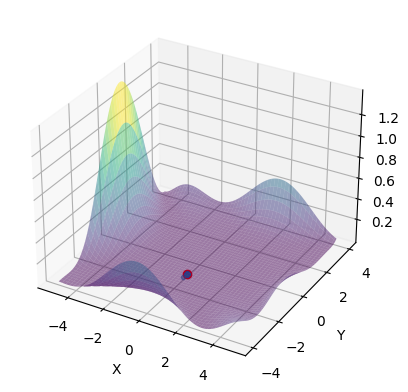

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Función Goldstein-Price
def goldstein_price(x, y):
    term1 = 1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)
    term2 = 30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2)
    return term1 * term2

pop_size = 50  # tamaño de la población
num_generations = 500  # número máximo de generaciones
mutation_rate = 0.1  # tasa de mutación

#Rango de búsqueda en x y y
#Este se puede definir como una matriz de tamaño 2xpop_size, donde pop_size es el tamaño de la población
population = np.random.uniform(low=-5, high=5, size=(pop_size, 2))

#------Definir la función de aptitud y selección------
#Inicializar la población: se puede inicializar la población de forma aleatoria en el espacio de búsqueda
#Evaluar la función de aptitud: para cada individuo de la población, se debe evaluar la función de Goldstein-Price y asignar un valor de aptitud
#Seleccionar los padres: se pueden seleccionar los padres para la siguiente generación utilizando el método de la ruleta
def tournament_selection(population, fitness, tournament_size):
    selected_parents = []
    for i in range(len(population)):
        tournament_indices = np.random.choice(len(population), size=tournament_size, replace=False)
        tournament_fitness = fitness[tournament_indices]
        tournament_population = population[tournament_indices]
        winner_index = np.argmin(tournament_fitness)
        selected_parents.append(tournament_population[winner_index])
    return np.array(selected_parents)

#------Definir la función de cruza------
#Cruzar los padres: se puede utilizar el método de cruce de dos puntos para cruzar los padres y generar la descendencia
def one_point_crossover(parents):
    children = []
    for i in range(0, len(parents), 2):
        parent1 = parents[i]
        parent2 = parents[i + 1]
        crossover_point = np.random.randint(1, len(parent1))
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        children.append(child1)
        children.append(child2)
    return np.array(children)

#------Definir la función de mutación------
#Mutar la descendencia: se puede aplicar una tasa de mutación y mutar los genes de la descendencia
def one_point_mutation(population, mutation_rate):
    for i in range(len(population)):
        if np.random.rand() < mutation_rate:
            mutation_point = np.random.randint(0, len(population[i]))
            population[i][mutation_point] += np.random.normal(0, 0.1)
    return population

#Reemplazar la población: se puede reemplazar la población actual con la descendencia generada
fitness = np.array([goldstein_price(x, y) for x, y in population])  


#Evaluar la convergencia: se puede evaluar si se ha llegado a la solución en menos de 500 iteraciones y, si es así, detener el algoritmo
for i in range(num_generations):
    parents = tournament_selection(population, fitness, tournament_size=3)
    children = one_point_crossover(parents)
    population = one_point_mutation(children, mutation_rate)
    fitness = np.array([goldstein_price(x, y) for x, y in population])  

    best_fitness = np.min(fitness)
    best_individual = population[np.argmin(fitness)]
    
    if i % 10 == 0:
        print("Generación", i)
        print("La mejor solución encontrada es:", best_individual)
        print("La aptitud correspondiente es:", best_fitness)
    
    if best_fitness < 1e-6:
        print("Se ha encontrado una solución óptima en la generación", i)
        break

#Grafica de la función
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-5, 5, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)
Z = goldstein_price(X, Y)

ax.plot(best_individual[0], best_individual[1], best_fitness, marker='o', color='red')
ax.plot(population[:, 0], population[:, 1], fitness, '.', alpha=0.5)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
